>
> # Shared rides with pricing

 ### Changes to:
 * shared.py
 * new function `pool_price.py` (with a debugging logs to see what is happening)
 * used inside `decisions.py\f_match
 * traveller.py (different routine - slightly)
 
 ### Usman choice logic to be applied inside `pool_price.py` 
 (now it is random choice)
 
 ### Tested for Delft, 10 paxes in 10 minutes is enough to debug
 > This notebook was fully working and not thoroughly tested


In [29]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


prepare

In [30]:
from MaaSSim.utils import get_config, load_G, prep_supply_and_demand, generate_demand, generate_vehicles, initialize_df  # simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.simulators import simulate
from MaaSSim.visualizations import plot_veh
from MaaSSim.shared import prep_shared_rides
import logging

In [31]:
import pandas as pd

In [32]:
import ExMAS

In [33]:
params = get_config('../../data/config/delft.json')  # load configuration

In [43]:
params.times.pickup_patience = 3600 # 1 hour of simulation
params.simTime = 0.1 # 6 minutes hour of simulation
params.nP = 8 # reuqests (and passengers)
params.nV = 8 # vehicles

In [44]:
params.t0 = pd.Timestamp.now()
params.shareability.avg_speed = params.speeds.ride
params.shareability.shared_discount = 0.3
params.shareability.delay_value = 1
params.shareability.WtS = 1.3
params.shareability.price = 1.5 #eur/km
params.shareability.VoT = 0.0035 #eur/s
params.shareability.matching_obj = 'u_pax' #minimize VHT for vehicles
params.shareability.pax_delay = 0
params.shareability.horizon = 600
params.shareability.max_degree = 4
params.shareability.nP = params.nP
params.shareability.share = 1
params.shareability.without_matching = True
params.shareability.operating_cost = 0.5
params.shareability.comm_rate = 0.2

In [45]:
inData = load_G(inData, params)  # load network graph 

In [46]:
inData = generate_demand(inData, params, avg_speed = False)
inData.vehicles = generate_vehicles(inData,params.nV)
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[1,'Uber',30]
params.shareability.share = 1
params.shareability.without_matching = True

In [47]:
inData = ExMAS.main(inData, params.shareability, plot=False) # create shareability graph (ExMAS) 

18-01-23 19:57:51-INFO-Initializing pairwise trip shareability between 8 and 8 trips.
18-01-23 19:57:51-INFO-creating combinations
18-01-23 19:57:51-INFO-56	 nR*(nR-1)
18-01-23 19:57:51-INFO-Reduction of feasible pairs by 92.86%
18-01-23 19:57:51-INFO-Degree 2 	Completed
18-01-23 19:57:51-INFO-trips to extend at degree 2 : 7
18-01-23 19:57:51-INFO-At degree 2 feasible extensions found out of 0 searched
18-01-23 19:57:51-INFO-Degree 3 	Completed
18-01-23 19:57:51-INFO-No more trips to exted at degree 3


In [48]:
inData = prep_shared_rides(inData, params.shareability) # prepare schedules

18-01-23 19:57:51-INFO-Matching 8 trips to 15 rides in order to min u_pax
18-01-23 19:57:51-INFO-Problem solution: Optimal. 
Total costs for single trips:             33 
reduced by matching to:                   30


In [49]:
inData.sblts.rides

,indexes,u_pax,u_veh,kind,u_paxes,times,indexes_orig,indexes_dest,degree,index,...,row,selected,nodes,req_id,sim_schedule,ttrav,dist,fare,commission,driver_revenue
0,[0],3.50100,189,1,[3.5010000000000003],"[0, 189]",[0],[0],1,0,...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1,"[None, 44718819, 44768932]","[None, 0, 0]",node time req_id od 0 NaN...,189,1.89,2.835,0.567,2.268
1,[1],9.15750,495,1,[9.157499999999999],"[6, 495]",[1],[1],1,1,...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,"[None, 1435362394, 44814943]","[None, 1, 1]",node time req_id od 0 ...,495,4.95,7.425,1.485,5.940
2,[2],5.79050,313,1,[5.7905],"[26, 313]",[2],[2],1,2,...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,"[None, 1436427109, 1552650415]","[None, 2, 2]",node time req_id od 0 ...,313,3.13,4.695,0.939,3.756
3,[3],4.00950,216,1,[4.0095],"[44, 216]",[3],[3],1,3,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",0,"[None, 30016605, 1569646491]","[None, 3, 3]",node time req_id od 0 ...,216,2.16,3.240,0.648,2.592
4,[4],3.02750,163,1,[3.0275],"[51, 163]",[4],[4],1,4,...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",1,"[None, 1361122139, 44827611]","[None, 4, 4]",node time req_id od 0 ...,163,1.63,2.445,0.489,1.956
5,[5],4.66200,252,1,[4.662],"[150, 252]",[5],[5],1,5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",0,"[None, 1385072819, 1413910851]","[None, 5, 5]",node time req_id od 0 ...,252,2.52,3.780,0.756,3.024
6,[6],1.52000,82,1,[1.52],"[210, 82]",[6],[6],1,6,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",0,"[None, 626010019, 44767578]","[None, 6, 6]",node time req_id od 0 N...,82,0.82,1.230,0.246,0.984
7,[7],1.65700,89,1,[1.657],"[303, 89]",[7],[7],1,7,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",0,"[None, 1436427083, 4617340492]","[None, 7, 7]",node time req_id od 0 ...,89,0.89,1.335,0.267,1.068
8,"[2, 1]",13.94855,840,20,"[5.0951249999999995, 8.853425]","[-30.5, 93, 248, 499]","[2, 1]","[2, 1]",2,8,...,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0,"[None, 1436427109, 1435362394, 1552650415, 448...","[None, 2, 1, 2, 1]",node time req_id od 0 ...,840,8.40,12.600,2.520,10.080
9,"[3, 5]",7.53060,346,20,"[3.53325, 3.9973499999999995]","[63.0, 68, 189, 89]","[3, 5]","[3, 5]",2,9,...,"[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]",1,"[None, 30016605, 1385072819, 1569646491, 14139...","[None, 3, 5, 3, 5]",node time req_id od 0 ...,346,3.46,5.190,1.038,4.152


In [50]:
inData.sblts.rides.keys()

Index(['indexes', 'u_pax', 'u_veh', 'kind', 'u_paxes', 'times', 'indexes_orig',
       'indexes_dest', 'degree', 'index', 'PassHourTrav_ns', 'row', 'selected',
       'nodes', 'req_id', 'sim_schedule', 'ttrav', 'dist', 'fare',
       'commission', 'driver_revenue'],
      dtype='object')

simulate

In [51]:
sim = simulate(params = params, inData = inData, logger_level = logging.WARNING) # simulate

18-01-23 19:57:53-INFO-Matching 8 trips to 15 rides in order to min u_pax
18-01-23 19:57:53-INFO-Problem solution: Optimal. 
Total costs for single trips:             33 
reduced by matching to:                   30
18-01-23 19:57:53-WARNING-Setting up 0.1h simulation at 2023-01-18 19:54:52 for 8 vehicles and 8 passengers in Delft, Netherlands
18-01-23 19:57:53-CRITICAL-this is request 1 with [1, 8, 11] available rides.
18-01-23 19:57:53-CRITICAL-ride 1 available [1]
18-01-23 19:57:53-CRITICAL-ride 8 available [0, 1]
18-01-23 19:57:53-CRITICAL-ride 11 available [1, 0]
18-01-23 19:57:53-CRITICAL-this is reuqest 1 with [1, 8, 11] still available rides.
18-01-23 19:57:53-CRITICAL-vehicle 8 has chosen to serve request 1 with a ride 8 of degree 2, with travellers [2, 1].
18-01-23 19:57:53-CRITICAL-this is request 2 with [2, 8, 12] available rides.
18-01-23 19:57:53-CRITICAL-ride 2 available [1]
18-01-23 19:57:53-CRITICAL-ride 8 not available [1, 3]
18-01-23 19:57:53-CRITICAL-ride 12 availab

In [27]:
pd.DataFrame(sim.vehs[3].myrides)

,veh,pos,t,event,paxes
0,3,4.795754e+08,0.0,STARTS_DAY,[]
1,3,4.795754e+08,0.0,OPENS_APP,[]
2,3,4.795754e+08,39.0,RECEIVES_REQUEST,[]
3,3,4.795754e+08,54.0,ACCEPTS_REQUEST,[]
4,3,4.795754e+08,74.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,3,4.795754e+08,246.0,IS_ACCEPTED_BY_TRAVELLER,[]
6,3,4.490330e+07,251.0,ARRIVES_AT_PICKUP,[]
7,3,4.490330e+07,251.0,MEETS_TRAVELLER_AT_PICKUP,[]
8,3,4.490330e+07,281.0,DEPARTS_FROM_PICKUP,[1]
9,3,4.261101e+09,477.0,ARRIVES_AT_PICKUP,[1]


In [28]:
sim.inData.requests.position

pax
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: position, dtype: int64

In [167]:
df = sim.runs[0].rides
df[df.veh==1]

,veh,pos,t,event,paxes
0,1,2.804814e+09,0.0,STARTS_DAY,[]
1,1,2.804814e+09,0.0,OPENS_APP,[]
2,1,2.804814e+09,0.0,RECEIVES_REQUEST,[]
3,1,2.804814e+09,15.0,ACCEPTS_REQUEST,[]
4,1,2.804814e+09,35.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,1,2.804814e+09,263.0,IS_ACCEPTED_BY_TRAVELLER,[]
6,1,1.584014e+09,561.0,ARRIVES_AT_PICKUP,[]
7,1,1.584014e+09,561.0,MEETS_TRAVELLER_AT_PICKUP,[]
8,1,1.584014e+09,591.0,DEPARTS_FROM_PICKUP,[0]
9,1,1.584637e+09,719.0,ARRIVES_AT_PICKUP,[0]


In [168]:
trips = sim.runs[0].trips
trips[trips.pax==8]

,pax,pos,t,event,veh_id


In [169]:
trips[trips.pax==0]

,pax,pos,t,event,veh_id
0,0,1584013904,0,STARTS_DAY,NaN
1,0,1584013904,0,REQUESTS_RIDE,NaN
2,0,1584013904,0,RECEIVES_OFFER,NaN
3,0,1584013904,15,ACCEPTS_OFFER,NaN
4,0,1584013904,35,ARRIVES_AT_PICKUP,1.0
5,0,1584013904,228,RECEIVES_OFFER,1.0
6,0,1584013904,561,MEETS_DRIVER_AT_PICKUP,1.0
7,0,1584013904,591,DEPARTS_FROM_PICKUP,1.0
8,0,44891422,1330,ARRIVES_AT_DROPOFF,1.0
9,0,44891422,1340,SETS_OFF_FOR_DEST,NaN


In [170]:
df[df.veh==1]

,veh,pos,t,event,paxes
0,1,2.804814e+09,0.0,STARTS_DAY,[]
1,1,2.804814e+09,0.0,OPENS_APP,[]
2,1,2.804814e+09,0.0,RECEIVES_REQUEST,[]
3,1,2.804814e+09,15.0,ACCEPTS_REQUEST,[]
4,1,2.804814e+09,35.0,IS_ACCEPTED_BY_TRAVELLER,[]
5,1,2.804814e+09,263.0,IS_ACCEPTED_BY_TRAVELLER,[]
6,1,1.584014e+09,561.0,ARRIVES_AT_PICKUP,[]
7,1,1.584014e+09,561.0,MEETS_TRAVELLER_AT_PICKUP,[]
8,1,1.584014e+09,591.0,DEPARTS_FROM_PICKUP,[0]
9,1,1.584637e+09,719.0,ARRIVES_AT_PICKUP,[0]


<AxesSubplot:>

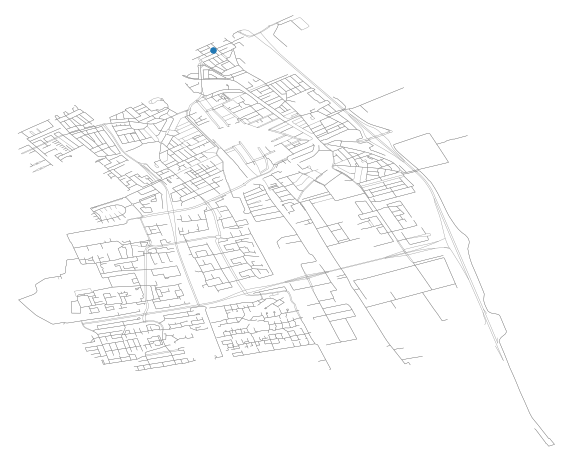

In [171]:
for i in range(params.nV):
    paxes = df[df.veh==i].paxes
    if paxes.apply(lambda x: len(x)).max()>1:
        break
plot_veh(inData.G, df[df.veh ==2], lw = 1)

-----